In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
from sklearn import model_selection
import pyro.contrib.gp as gp

import torch
import numpy as np
import seaborn as sns
import arviz as az  


/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


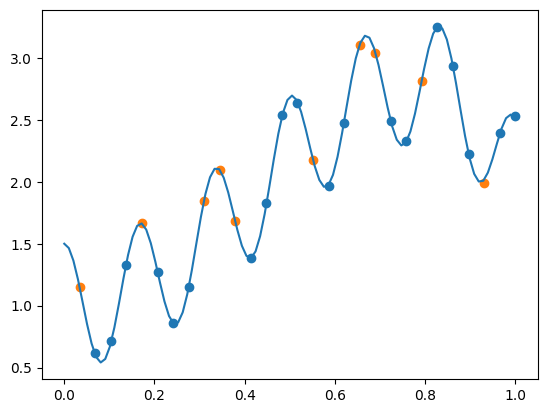

Area less than q True


In [2]:
q = 2 
def func(x):
    return - np.power((np.sin(6*np.pi*x)),2) + 6*np.power(x,2) - 5*np.power(x,4) + (3/2)
x= np.linspace(0,1,100)
y = func(x)
def datafunc(x):
    return func(x) + np.random.normal(0, 0.01, func(x).shape)
def gendata(l):
    x = np.array(range(1,l))/(l-1)
    y = datafunc(x)   
    return x,y
data  = gendata(30)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[0], data[1], test_size= 10)
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)
plt.plot(x,y)
plt.show()
print ("Area less than q", np.sum(y)/100 <q )

In [3]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

def kernel(X, Z, variance, lengthscale):
    # Expand X and Z to calculate pairwise squared distances
    X = X.unsqueeze(-1) if X.dim() == 1 else X  # Ensure X is 2D
    Z = Z.unsqueeze(-1) if Z.dim() == 1 else Z  # Ensure Z is 2D
    pairwise_sq_dists = (X - Z.T).pow(2)  # Pairwise squared differences
    calc = variance.pow(2) * torch.exp(-0.5 * pairwise_sq_dists / lengthscale.pow(2))
    return calc


def model(X, Y): #måske lognormal for at sikre os positive tal
    variance = pyro.sample("variance", dist.Normal(4, .1))
    lengthscale = pyro.sample("lengthscale", dist.Normal(0.01, 0.02))
    noise = pyro.sample("noise", dist.Normal(0, .01))
    # Covariance matrix
    K = kernel(X, X, variance, lengthscale) + torch.eye(X.shape[0]) * noise.pow(2)
    # Sample from the multivariate normal
    y = pyro.sample(    
        "y", dist.MultivariateNormal(torch.zeros(X.shape[0]), covariance_matrix=K), obs=Y
    )
    return y

#X_train = torch.tensor([[1.0], [2.0], [3.0]])  # Example data
#y_train = torch.tensor([1.0, 2.0, 3.0])  # Example data

#warmup = [10, 50, 100, 300]
#chains = [4]


X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=4)
mcmc.run(X_train, y_train)
#mcmc.summary()
posterior_samples = mcmc.get_samples()
#print(posterior_samples)
nuts_inference = az.from_pyro(mcmc)
nuts_summary = az.summary(nuts_inference, var_names=["variance", "lengthscale", "noise"])
print(nuts_summary)
pyro.clear_param_store()
        


Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]


Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 1/600 [00:01,  1.34s/it, step size=2.25e-01, acc. prob=1.000]

Warmup [2]:   0%|          | 3/600 [00:01,  2.56it/s, step size=3.75e-03, acc. prob=0.333]


Warmup [1]:   0%|          | 1/600 [00:01,  1.68s/it, step size=4.50e-01, acc. prob=1.000]

Warmup [3]:   1%|          | 4/600 [00:01,  2.93it/s, step size=5.07e-03, acc. prob=0.500]


Warmup [1]:   1%|          | 4/600 [00:01,  2.53it/s, step size=3.91e-03, acc. prob=0.417]

Warmup [1]:   1%|          | 5/600 [00:02,  3.06it/s, step size=5.87e-03, acc. prob=0.533]


Warmup [4]:   1%|          | 4/600 [00:02,  2.29it/s, step size=5.07e-03, acc. prob=0.500]

Warmup [3]:   1%|          | 7/600 [00:02,  4.35it/s, step size=8.57e-03, acc. prob=0.667]

Warmup [1]:   1%|          | 6/600 [00:02,  3.15it/s, step size=3.50e-03, acc. prob=0.556]


Warmup [1]:   

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
variance     2.874  1.915  -0.476    4.129      0.949    0.726       7.0   
lengthscale  0.036  0.070  -0.089    0.092      0.035    0.027       5.0   
noise       -0.000  0.010  -0.020    0.019      0.000    0.000     555.0   

             ess_tail  r_hat  
variance         29.0   1.53  
lengthscale      38.0   2.29  
noise           552.0   1.02  


/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


# print("NUTS Summary (R-hat and ESS):")
print(nuts_summary)

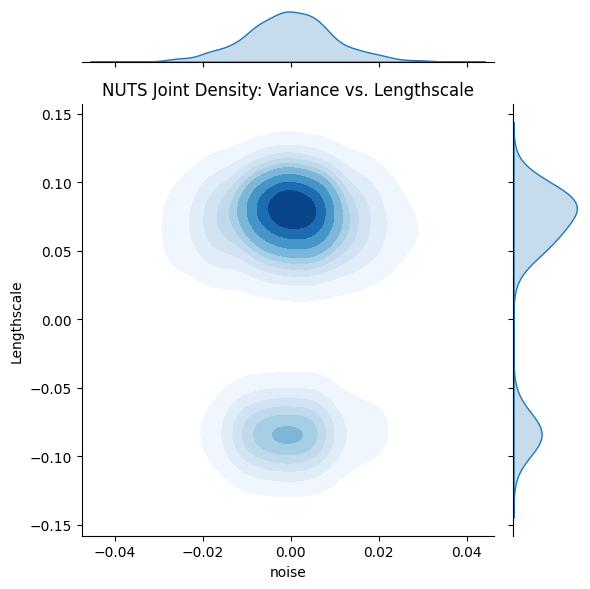

In [4]:
sns.jointplot(
    x=posterior_samples["noise"].numpy(),
    y=posterior_samples["lengthscale"].numpy(),
    kind="kde",
    fill=True,
    cmap="Blues"
)
plt.xlabel("noise")
plt.ylabel("Lengthscale")
plt.title("NUTS Joint Density: Variance vs. Lengthscale")
plt.tight_layout()
plt.show()

In [5]:
def compute_posterior_likelihood(X_train, Y_train, X_test, Y_test, posterior_samples):
    likelihoods = []
    means = []
    var = []
    for i in range(posterior_samples["variance"].shape[0]):
        variance = posterior_samples["variance"][i]
        lengthscale = posterior_samples["lengthscale"][i]
        noise = posterior_samples["noise"][i]

        
        # Compute kernel matrices
        K_train = kernel(X_train, X_train, variance, lengthscale) + torch.eye(X_train.shape[0]) * noise.pow(2)
        K_train_test = kernel(X_train, X_test, variance, lengthscale)
        K_test = kernel(X_test, X_test, variance, lengthscale) + torch.eye(X_test.shape[0]) * noise.pow(2)
        
        # Compute predictive mean and covariance
        K_train_inv = torch.linalg.inv(K_train)
        pred_mean = K_train_test.T @ K_train_inv @ Y_train
        pred_cov = K_test - K_train_test.T @ K_train_inv @ K_train_test
        
        # Compute log-likelihood for test set
        dist_pred = dist.MultivariateNormal(pred_mean, covariance_matrix=pred_cov)
        log_likelihood = dist_pred.log_prob(Y_test)
        likelihoods.append(log_likelihood.item())
        means.append(pred_mean)
        var.append(torch.clip(torch.diag(pred_cov), 0.0))
    
    # Average log-likelihood across all posterior samples
    avg_log_likelihood = torch.tensor(likelihoods).mean()
    print("here")
    #means = torch.tensor(means).mean()
    #var = torch.tensor(var).mean()
    return avg_log_likelihood#, means, var

print(posterior_samples)

    
# Example usage
X_test = torch.tensor(X_test)  # Exampkernelle test data
Y_test = torch.tensor(y_test)  # Example test observations

log_likelihood = compute_posterior_likelihood(X_train, y_train, X_test, Y_test, posterior_samples)

#plot_gp_predictions(means, var, X_test)
print("Approximate Posterior Log-Likelihood:", log_likelihood)
#np.exp(log_likelihood)

{'lengthscale': tensor([0.0900, 0.0820, 0.0795,  ..., 0.0832, 0.0834, 0.0896],
       dtype=torch.float64), 'noise': tensor([-0.0109,  0.0147,  0.0171,  ...,  0.0031,  0.0029,  0.0020],
       dtype=torch.float64), 'variance': tensor([4.0971, 3.9976, 3.9384,  ..., 4.0219, 3.8425, 4.1106],
       dtype=torch.float64)}
here
Approximate Posterior Log-Likelihood: tensor(-19.5261)


In [97]:
diction = dict(zip(["variance", "lengthscale", "noise"], [torch.tensor([-1.813]), torch.tensor([0.074]), torch.tensor([0.01])]))

#np.exp(compute_posterior_likelihood(X_train, y_train, X_test, Y_test, diction))
tensor(5.0084)
tensor(0.0811)

tensor(3.0106)
tensor(0.1003)

tensor(4.7545)
tensor(0.0625)

tensor(3.6494)
tensor(0.1509)

tensor(3.8718)
tensor(0.0850)

tensor(3.3535)
tensor(0.1282)


tensor(4.3329)
tensor(0.1246)

tensor(3.8156)
tensor(0.0944)


tensor(1.6870)
tensor(0.0985)

tensor(4.3958)
tensor(0.0633)


tensor(3.6715)
tensor(0.0879)

tensor(4.6589)
tensor(0.1477)

tensor(4.2300)
tensor(0.0689)

tensor(5.5172)
tensor(0.1104)

tensor(2.4803)
tensor(0.0844)

tensor(2.9885)
tensor(0.0941)

tensor(4.4556)
tensor(0.1190)

tensor(6.0772)
tensor(0.1189)

tensor(4.2608)
tensor(0.1051)

tensor(3.9767)
tensor(0.1036)


AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [7]:
MAP_values = [
    {'variance': torch.tensor([5.0084]), 'lengthscale': torch.tensor([0.0811]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.0106]), 'lengthscale': torch.tensor([0.1003]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.7545]), 'lengthscale': torch.tensor([0.0625]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.6494]), 'lengthscale': torch.tensor([0.1509]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.8718]), 'lengthscale': torch.tensor([0.0850]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.3535]), 'lengthscale': torch.tensor([0.1282]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.3329]), 'lengthscale': torch.tensor([0.1246]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.8156]), 'lengthscale': torch.tensor([0.0944]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([1.6870]), 'lengthscale': torch.tensor([0.0985]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.3958]), 'lengthscale': torch.tensor([0.0633]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.6715]), 'lengthscale': torch.tensor([0.0879]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.6589]), 'lengthscale': torch.tensor([0.1477]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.2300]), 'lengthscale': torch.tensor([0.0689]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([5.5172]), 'lengthscale': torch.tensor([0.1104]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([2.4803]), 'lengthscale': torch.tensor([0.0844]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([2.9885]), 'lengthscale': torch.tensor([0.0941]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.4556]), 'lengthscale': torch.tensor([0.1190]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([6.0772]), 'lengthscale': torch.tensor([0.1189]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([4.2608]), 'lengthscale': torch.tensor([0.1051]), 'noise': torch.tensor([0.01])},
    {'variance': torch.tensor([3.9767]), 'lengthscale': torch.tensor([0.1036]), 'noise': torch.tensor([0.01])}
]

loglik = []
for i in MAP_values:
    X_test = torch.tensor(X_test)  # Exampkernelle test data
    Y_test = torch.tensor(y_test)  # Example test observations
    
    log_likelihood = compute_posterior_likelihood(X_train, y_train, X_test, Y_test, i)
    loglik.append(log_likelihood)



here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


/tmp/ipykernel_89649/1518558652.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)  # Exampkernelle test data


In [9]:
filtered = np.where(np.array(loglik) < -400, 0, loglik)
print(np.mean(loglik))
print(np.std(loglik))
print(np.mean(filtered))
print(np.std(filtered))
print(loglik)     

-428.52643
1219.7798
-2.5635276
40.190002
[tensor(14.0622), tensor(13.5471), tensor(4.3373), tensor(-4775.6992), tensor(16.0001), tensor(-533.2916), tensor(-167.8167), tensor(16.6106), tensor(5.2235), tensor(5.4580), tensor(16.4969), tensor(-3210.2664), tensor(9.1217), tensor(10.4587), tensor(16.5960), tensor(16.2435), tensor(-42.0627), tensor(-12.3396), tensor(13.1059), tensor(13.6871)]


In [ ]:
tensor(-41.2419)
tensor(-13.2718)
tensor(-98.9618)
tensor(9.8852)

tensor(-59.4209)
tensor(-3.3545)
tensor(-12.5851)
tensor(-19.5261)




In [6]:
NUTS_LIKELYHOODS = [-41.2419, -13.2718, -98.9618, 9.8852, -59.4209, -3.3545, -12.5851,-19.5261]
print(np.mean(NUTS_LIKELYHOODS))
print(np.std(NUTS_LIKELYHOODS))

-29.8096125
33.05494554565313
